In [1]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
wd = os.getcwd()
raw_from_source = os.path.join(wd,'raw-from-source')

# Hawai'i 2022 Election Results and Precinct Boundaries Processing

- Hawai'i 2022 General Election Precinct Results from [MEDSL](https://github.com/MEDSL/2022-elections-official/tree/main/individual_states)
- Hawai'i Precinct Boundaries from the [Hawai'i Statewide GIS Program](https://geoportal.hawaii.gov/datasets/HiStateGIS::election-precincts/explore?location=20.555300%2C-157.490700%2C8.41)
- Official PDF Precinct Level Results from [Hawai'i Office of Elections](https://elections.hawaii.gov/election-results/)

### Prepare Election Results

Import MEDSL Precinct Results

In [2]:
elec = pd.read_csv(os.path.join(raw_from_source,'HI-cleaned.csv'))
elec.head()

,precinct,district,office,writein,party_detailed,party_simplified,candidate,dataverse,mode,votes,...,state_fips,state_cen,state_ic,date,jurisdiction_fips,county_name,county_fips,readme_check,magnitude,special
0,01-01,NaN,US SENATE,False,LIBERTARIAN,LIBERTARIAN,FEENA M BONOAN,SENATE,MAIL IN,35,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False
1,01-01,NaN,US SENATE,False,ALOHA AINA PARTY,OTHER,DAN DECKER,SENATE,MAIL IN,19,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False
2,01-01,NaN,US SENATE,False,REPUBLICAN,REPUBLICAN,BOB MCDERMOTT,SENATE,MAIL IN,609,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False
3,01-01,NaN,US SENATE,False,GREEN,OTHER,EMMA JANE A POHLMAN,SENATE,MAIL IN,29,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False
4,01-01,NaN,US SENATE,False,DEMOCRAT,DEMOCRAT,BRIAN SCHATZ,SENATE,MAIL IN,2521,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False


Clean fields and create a unique contest field (combine office and district fields)

In [3]:
elec['district'] = elec['district'].apply(lambda x: str(x).split('.')[0])
elec['district'] = elec['district'].apply(lambda x: x.strip())
elec['office'] = elec['office'].apply(lambda x: x.strip())
elec['contest_name'] = elec.apply(lambda x: x['office']+ ' - '+x['district']  if x['district']!='nan' else x['office'],axis=1)

Check which contests are in all precincts

In [4]:
unique_precincts = list(elec['precinct'].unique())
all_contests = sorted(list(elec['contest_name'].unique()))
len_all_contests = len(all_contests)
listofzeros = [0] * len_all_contests
num_precs = len(unique_precincts)
contests_dict = dict(zip(all_contests,listofzeros))
in_all_precincts = []
for i in unique_precincts:
    sub_df = elec[elec['precinct']==i]
    contests = list(sub_df['contest_name'].unique())
    for contest in contests:
        contests_dict[contest] = int(contests_dict.get(contest))+1
contests_keep =[]
for k,v in contests_dict.items():
    if v>200:
        print(k,'\t',v)
        contests_keep.append(k)
print(contests_keep)

AT-LARGE TRUSTEE 	 234
GOVERNOR 	 236
HAWAII RESIDENT TRUSTEE VACANCY 	 235
US SENATE 	 236
['AT-LARGE TRUSTEE', 'GOVERNOR', 'HAWAII RESIDENT TRUSTEE VACANCY', 'US SENATE']


In [5]:
for i in unique_precincts:
    sub_df = elec[elec['precinct']==i]
    sub_contests = list(sub_df['contest_name'].unique())
    for cont in contests_keep:
        if cont not in sub_contests:
            print(cont, ' is missing from: ', i)

AT-LARGE TRUSTEE  is missing from:  05-04
AT-LARGE TRUSTEE  is missing from:  01-04
HAWAII RESIDENT TRUSTEE VACANCY  is missing from:  01-04


Query file to just the contests of interest

In [6]:
contests_keep = contests_keep+['STATE HOUSE - 11', 'STATE HOUSE - 12', 'STATE HOUSE - 13', 'STATE HOUSE - 14', 'STATE HOUSE - 15', 'STATE HOUSE - 16', 'STATE HOUSE - 17', 'STATE HOUSE - 19', 'STATE HOUSE - 20', 'STATE HOUSE - 21', 'STATE HOUSE - 22', 'STATE HOUSE - 24', 'STATE HOUSE - 25', 'STATE HOUSE - 26', 'STATE HOUSE - 27', 'STATE HOUSE - 28', 'STATE HOUSE - 29', 'STATE HOUSE - 3', 'STATE HOUSE - 30', 'STATE HOUSE - 32', 'STATE HOUSE - 34', 'STATE HOUSE - 35', 'STATE HOUSE - 36', 'STATE HOUSE - 37', 'STATE HOUSE - 38', 'STATE HOUSE - 39', 'STATE HOUSE - 4', 'STATE HOUSE - 40', 'STATE HOUSE - 41', 'STATE HOUSE - 42', 'STATE HOUSE - 43', 'STATE HOUSE - 44', 'STATE HOUSE - 45', 'STATE HOUSE - 46', 'STATE HOUSE - 47', 'STATE HOUSE - 48', 'STATE HOUSE - 49', 'STATE HOUSE - 5', 'STATE HOUSE - 50', 'STATE HOUSE - 51', 'STATE HOUSE - 6', 'STATE HOUSE - 8', 'STATE SENATOR - 1', 'STATE SENATOR - 10', 'STATE SENATOR - 11', 'STATE SENATOR - 12', 'STATE SENATOR - 13', 'STATE SENATOR - 14', 'STATE SENATOR - 15', 'STATE SENATOR - 16', 'STATE SENATOR - 17', 'STATE SENATOR - 18', 'STATE SENATOR - 2', 'STATE SENATOR - 21', 'STATE SENATOR - 22', 'STATE SENATOR - 23', 'STATE SENATOR - 24', 'STATE SENATOR - 25', 'STATE SENATOR - 4', 'STATE SENATOR - 6', 'STATE SENATOR - 7', 'STATE SENATOR - 8', 'STATE SENATOR - 9', 'US HOUSE - 1', 'US HOUSE - 2', 'US SENATE']
cols_keep = ['precinct','contest_name','district','office','party_detailed','candidate','dataverse','mode','votes','county_name','county_fips']
elec_keep = elec[elec['contest_name'].isin(contests_keep)]
elec_keep = elec_keep[cols_keep]
elec_keep

,precinct,contest_name,district,office,party_detailed,candidate,dataverse,mode,votes,county_name,county_fips
0,01-01,US SENATE,nan,US SENATE,LIBERTARIAN,FEENA M BONOAN,SENATE,MAIL IN,35,HAWAII,15001
1,01-01,US SENATE,nan,US SENATE,ALOHA AINA PARTY,DAN DECKER,SENATE,MAIL IN,19,HAWAII,15001
2,01-01,US SENATE,nan,US SENATE,REPUBLICAN,BOB MCDERMOTT,SENATE,MAIL IN,609,HAWAII,15001
3,01-01,US SENATE,nan,US SENATE,GREEN,EMMA JANE A POHLMAN,SENATE,MAIL IN,29,HAWAII,15001
4,01-01,US SENATE,nan,US SENATE,DEMOCRAT,BRIAN SCHATZ,SENATE,MAIL IN,2521,HAWAII,15001
...,...,...,...,...,...,...,...,...,...,...,...
16542,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,NaN,BRICKWOOD GALUTERIA,STATE,ELECTION DAY,12,HONOLULU,15003
16543,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,NaN,SAM 'KALANIKUPUA' KING,STATE,ELECTION DAY,21,HONOLULU,15003
16544,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,NaN,CHAD OWENS,STATE,ELECTION DAY,20,HONOLULU,15003
16545,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,NaN,KEONI SOUZA,STATE,ELECTION DAY,31,HONOLULU,15003


Create columns to pivot on using standard naming conventions

In [7]:
col_name_dict = {'US SENATE':'G22USS','AT-LARGE TRUSTEE':'G22ALT','GOVERNOR':'G22GOV','HAWAII RESIDENT TRUSTEE VACANCY':'G22HRT'}

for i in sorted(elec_keep['contest_name'].unique()):
    if i not in col_name_dict.keys():
        dist_num = str(str(i.split(' - ')[1]).zfill(2))
        if 'STATE HOUSE' in i:
            name = 'GSLL'+dist_num
        elif 'STATE SEN' in i:
            name = 'GSLU'+dist_num
        else:
            name = 'GCON'+dist_num
        col_name_dict.update({i:name})

In [8]:
elec_keep['base_name'] = elec_keep['contest_name'].map(col_name_dict)
elec_keep['party_letter'] = elec_keep['party_detailed'].apply(lambda x: str(x)[0].upper())
elec_keep['name3'] = elec_keep['candidate'].apply(lambda x: str(x).split(' ')[-1][0:3])
elec_keep['name3'] = elec_keep['name3'].apply(lambda x: str(x)+'K' if x=='HO' else x)
elec_keep['full_name'] = elec_keep['base_name']+elec_keep['party_letter']+elec_keep['name3']
cols_keep = ['precinct','votes','full_name']
elec_sub = elec_keep[cols_keep]
display(elec_sub.head())

,precinct,votes,full_name
0,01-01,35,G22USSLBON
1,01-01,19,G22USSADEC
2,01-01,609,G22USSRMCD
3,01-01,29,G22USSGPOH
4,01-01,2521,G22USSDSCH


Pivot the election results on the standardized names

In [9]:
pivot = elec_sub.pivot_table(index='precinct',columns = ['full_name'],values=['votes'],aggfunc=sum)
pivot.reset_index(inplace=True,drop=False)
pivot.columns = [col[1] for col in pivot.columns]
pivot.rename(columns = {'':'UNIQUE_ID'},inplace=True)
for i in pivot.columns:
    if i == 'UNIQUE_ID':
        pivot[i] = pivot[i].apply(lambda x: str(x))
    else:
        pivot[i] = pivot[i].fillna(0)
        pivot[i] = pivot[i].apply(lambda x: int(x))
display(pivot.head())

,UNIQUE_ID,G22ALTNGAL,G22ALTNISA,G22ALTNKIN,G22ALTNOWE,G22ALTNSOU,G22ALTNWAI,G22GOVDGRE,G22GOVRAIO,G22HRTNCER,...,GSLU21DGAB,GSLU21RKHA,GSLU22DSHI,GSLU22RDEC,GSLU23DRIV,GSLU23RAWA,GSLU24DKEO,GSLU24RFER,GSLU25DLEE,GSLU25RLAU
0,01-01,1098,746,764,765,1309,1164,2343,985,816,...,0,0,0,0,0,0,0,0,0,0
1,01-02,689,559,502,544,772,810,1544,675,532,...,0,0,0,0,0,0,0,0,0,0
2,01-03,1149,813,662,805,1189,1086,2243,1098,739,...,0,0,0,0,0,0,0,0,0,0
3,01-04,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,02-01,1916,1268,1024,1274,1595,1845,3687,1503,1173,...,0,0,0,0,0,0,0,0,0,0


### Prepare Precinct Boundaries

Read in shapefile and check what column is unique or the closest to being unique.

In [10]:
precincts = gp.read_file(os.path.join(raw_from_source,'Election_Precincts.geojson'))
print(list(precincts.columns))

['objectid', 'dp', 'dpnum', 'dptype', 'county', 'zeropop', 'ballottype_50', 'us_house', 'state_house', 'state_senate', 'county_council', 'st_areashape', 'st_perimetershape', 'geometry']


In [11]:
precincts = gp.read_file(os.path.join(raw_from_source,'Election_Precincts.geojson'))
col_len_dict = {}
prec_len = len(precincts)
for i in list(precincts.columns):
    if i not in ['geometry','objectid','st_areashape','st_perimetershape']:
        unique_count = len(precincts[i].unique())
        col_len_dict.update({i:unique_count})
best_fit = ''
best_fit_len = 0
for k,v in col_len_dict.items():
    if best_fit =='':
        best_fit = k
        best_fit_len = v
    else:
        if v>best_fit_len:
            best_fit = k
            best_fit_len = v
print(best_fit)
print('Difference between unique precincts and length of best fit column for unique ID: ', prec_len - best_fit_len)

dp
Difference between unique precincts and length of best fit column for unique ID:  2


Determine where columns 'dp' has the same values.

42-01


,objectid,dp,dpnum,dptype,county,zeropop,ballottype_50,us_house,state_house,state_senate,county_council,st_areashape,st_perimetershape,geometry,duplicated
246,247,42-01,4201,VBMO,OAHU,,CD1-H42-S20-CC9,CD1,H42,S20,CC9,92198.471050,1370.015977,"POLYGON ((-158.03044 21.33709, -158.02942 21.3...",False
247,248,42-01,4201,VBMO,OAHU,,CD1-H42-S20-CC9,CD1,H42,S20,CC9,215295.378292,2002.045649,"POLYGON ((-158.02814 21.34041, -158.02769 21.3...",True


18-05


,objectid,dp,dpnum,dptype,county,zeropop,ballottype_50,us_house,state_house,state_senate,county_council,st_areashape,st_perimetershape,geometry,duplicated
248,249,18-05,1805,VBMO,OAHU,,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.572862e+05,2852.785704,"POLYGON ((-157.71873 21.28422, -157.71872 21.2...",False
249,250,18-05,1805,VBMO,OAHU,,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.780304e+06,11075.929342,"POLYGON ((-157.70717 21.31775, -157.70734 21.3...",True


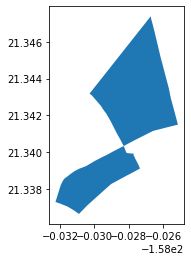

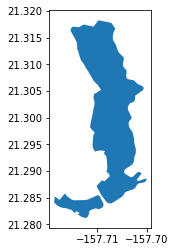

In [12]:
precincts['duplicated'] = precincts.duplicated(subset=best_fit)
duplicated_values = list(precincts[precincts['duplicated']==True][best_fit].unique())
for i in duplicated_values:
    dup_gdf = precincts[precincts[best_fit]==i]
    print(i)
    display(dup_gdf)
    dup_gdf.plot()

Duplicated precincts should be multi-poloygons so dissolve on 'dp' to make the field unique

In [13]:
precs = precincts.dissolve(by=best_fit)
precs.reset_index(inplace=True,drop=False)
display(precs.head())

,dp,geometry,objectid,dpnum,dptype,county,zeropop,ballottype_50,us_house,state_house,state_senate,county_council,st_areashape,st_perimetershape,duplicated
0,01-01,"POLYGON ((-155.69865 20.18589, -155.69903 20.1...",1,101,VBMO,HAWAII,,CD2-H01-S04-CC1,CD2,H01,S04,CC1,9.949400e+08,243835.454121,False
1,01-02,"POLYGON ((-155.08329 19.85094, -155.08329 19.8...",2,102,VBMO,HAWAII,,CD2-H01-S01-CC1,CD2,H01,S01,CC1,1.996375e+08,90596.525487,False
2,01-03,"POLYGON ((-155.33399 19.78996, -155.33422 19.7...",3,103,VBMO,HAWAII,,CD2-H01-S01-CC2,CD2,H01,S01,CC2,4.157142e+08,96097.575789,False
3,01-04,"POLYGON ((-155.43905 19.90430, -155.43920 19.9...",4,104,ZEROPOP,HAWAII,yes,CD2-H01-S04-CC2,CD2,H01,S04,CC2,4.202857e+08,100538.651270,False
4,02-01,"POLYGON ((-155.08683 19.72785, -155.08688 19.7...",5,201,VBMO,HAWAII,,CD2-H02-S01-CC2,CD2,H02,S01,CC2,1.954235e+07,28533.769583,False


Add county FIPS assignments and rename columns to match standardization

In [14]:
precs['dp'] = precs['dp'].apply(lambda x: str(x))
precs['county'] = precs['county'].apply(lambda x: 'HONOLULU' if x=='OAHU' else x)
precs['county_fips'] = precs['county'].map({'HAWAII': '15001', 'MAUI': '15009', 'KAUAI': '15007', 'HONOLULU': '15003'})
col_dict =  {'dp':'UNIQUE_ID','county':'COUNTYNM','county_fips':'COUNTYFP','us_house':'CON_DIST','state_house':'SLL_DIST','state_senate':'SLU_DIST'}
precs.rename(columns =col_dict,inplace=True)
display(precs.head())

,UNIQUE_ID,geometry,objectid,dpnum,dptype,COUNTYNM,zeropop,ballottype_50,CON_DIST,SLL_DIST,SLU_DIST,county_council,st_areashape,st_perimetershape,duplicated,COUNTYFP
0,01-01,"POLYGON ((-155.69865 20.18589, -155.69903 20.1...",1,101,VBMO,HAWAII,,CD2-H01-S04-CC1,CD2,H01,S04,CC1,9.949400e+08,243835.454121,False,15001
1,01-02,"POLYGON ((-155.08329 19.85094, -155.08329 19.8...",2,102,VBMO,HAWAII,,CD2-H01-S01-CC1,CD2,H01,S01,CC1,1.996375e+08,90596.525487,False,15001
2,01-03,"POLYGON ((-155.33399 19.78996, -155.33422 19.7...",3,103,VBMO,HAWAII,,CD2-H01-S01-CC2,CD2,H01,S01,CC2,4.157142e+08,96097.575789,False,15001
3,01-04,"POLYGON ((-155.43905 19.90430, -155.43920 19.9...",4,104,ZEROPOP,HAWAII,yes,CD2-H01-S04-CC2,CD2,H01,S04,CC2,4.202857e+08,100538.651270,False,15001
4,02-01,"POLYGON ((-155.08683 19.72785, -155.08688 19.7...",5,201,VBMO,HAWAII,,CD2-H02-S01-CC2,CD2,H02,S01,CC2,1.954235e+07,28533.769583,False,15001


In [15]:
precs_keep = precs[list(col_dict.values())+['geometry']]
display(precs_keep.head())

,UNIQUE_ID,COUNTYNM,COUNTYFP,CON_DIST,SLL_DIST,SLU_DIST,geometry
0,01-01,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69903 20.1..."
1,01-02,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.08329 19.85094, -155.08329 19.8..."
2,01-03,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.33399 19.78996, -155.33422 19.7..."
3,01-04,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.43905 19.90430, -155.43920 19.9..."
4,02-01,HAWAII,15001,CD2,H02,S01,"POLYGON ((-155.08683 19.72785, -155.08688 19.7..."


See which precincts are in just the election results or just the boundaries.

In [16]:
elec_precs_list = sorted(list(elec_keep['precinct'].unique()))
shp_precs_list = sorted(list(precs_keep['UNIQUE_ID'].unique()))

elec_only = []
for i in elec_precs_list:
    if i not in shp_precs_list:
        elec_only.append(i)
print('In the election results only: ', elec_only)
shp_only = []
for i in shp_precs_list:
    if i not in elec_precs_list:
        shp_only.append(i)
print('In the boundaries only: ', shp_only)

In the election results only:  []
In the boundaries only:  ['04-04', '05-01', '05-07', '05-08', '05-09', '05-10', '07-06', '07-07', '13-10', '36-04', '37-04', '46-01']


Verify that these precincts contain no people using QGIS

In [17]:
shp_only_precs = precs_keep[precs_keep['UNIQUE_ID'].isin(shp_only)]
shp_only_precs.to_file(os.path.join(wd,'precincts_not_in_election_results.geojson'),driver='GeoJSON')

After checking in QGIS and a basemap layer, we can confirm that the precincts that are only in the boundary file are precincts that contain no population, and therefore should not have any election results.

In [18]:
joined = pd.merge(precs_keep,pivot,how='outer',indicator=True)
for i in joined.columns:
    if i not in ['UNIQUE_ID','_merge']:
        joined[i] = joined[i].fillna(0)
print(joined['_merge'].value_counts())

both          236
left_only      12
right_only      0
Name: _merge, dtype: int64


In [19]:
left_only = joined[joined['_merge']=='left_only']
left_only_ids = sorted(list(left_only['UNIQUE_ID']))
assert(left_only_ids == shp_only)

Reorder columns before export

In [20]:
initial_columns = ['UNIQUE_ID', 'COUNTYNM', 'COUNTYFP', 'CON_DIST', 'SLU_DIST', 'SLL_DIST']
con_cols = []
sll_cols = []
slu_cols = []
state_cols = []
for i in joined.columns:
    if i not in initial_columns:
        if i.startswith('GCON'):
            con_cols.append(i)
        elif i.startswith('GSLL'):
            sll_cols.append(i)
        elif i.startswith('GSLU'):
            slu_cols.append(i)
        elif i not in ['geometry','_merge']:
            state_cols.append(i)
order = initial_columns + state_cols + con_cols + slu_cols + sll_cols + ['geometry']
final = joined[order]
display(final.head())

,UNIQUE_ID,COUNTYNM,COUNTYFP,CON_DIST,SLU_DIST,SLL_DIST,G22ALTNGAL,G22ALTNISA,G22ALTNKIN,G22ALTNOWE,...,GSLL47RTAL,GSLL48DKIT,GSLL48RELE,GSLL49DMAT,GSLL49RDAN,GSLL50DHUS,GSLL50RTHU,GSLL51DMAR,GSLL51RKAM,geometry
0,01-01,HAWAII,15001,CD2,S04,H01,1098.0,746.0,764.0,765.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-155.69865 20.18589, -155.69903 20.1..."
1,01-02,HAWAII,15001,CD2,S01,H01,689.0,559.0,502.0,544.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-155.08329 19.85094, -155.08329 19.8..."
2,01-03,HAWAII,15001,CD2,S01,H01,1149.0,813.0,662.0,805.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-155.33399 19.78996, -155.33422 19.7..."
3,01-04,HAWAII,15001,CD2,S04,H01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-155.43905 19.90430, -155.43920 19.9..."
4,02-01,HAWAII,15001,CD2,S01,H02,1916.0,1268.0,1024.0,1274.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-155.08683 19.72785, -155.08688 19.7..."


Verify that precinct boundary district assignments match those based on election results to ensure precincts have just votes for one district per level

In [21]:
list_of_cancelled_contests_sll = [['01'], ['02'], ['07'], ['09'], ['10'], ['18'], ['23'], ['31'], ['33']]
list_of_cancelled_contests_slu = [['03'],['05'],['19'],['20']]
# https://ballotpedia.org/Hawaii_House_of_Representatives_elections,_2022

In [22]:
for i in list(final['UNIQUE_ID']):
    if i not in left_only_ids:
        sub_df = final[final['UNIQUE_ID']==i]
        con_dist = [list(sub_df['CON_DIST'])[0].replace('CD','').zfill(2)]
        sll_dist = [list(sub_df['SLL_DIST'])[0].replace('H','').zfill(2)]
        slu_dist = [list(sub_df['SLU_DIST'])[0].replace('S','').zfill(2)]
        con_o0 = []
        for col in con_cols:
            if sub_df[col].sum()>0:
                dist = str(col[4:6])
                con_o0.append(dist)
        con_o0 = list(set(con_o0))
        sll_o0 = []
        for col in sll_cols:
            if sub_df[col].sum()>0:
                dist = str(col[4:6])
                sll_o0.append(dist)
        sll_o0 = list(set(sll_o0))
        slu_o0 = []
        for col in slu_cols:
            if sub_df[col].sum()>0:
                dist = str(col[4:6])
                slu_o0.append(dist)
        slu_o0 = list(set(slu_o0))
        if con_dist != con_o0:
            print('Difference in CONG for: ', i)
            print('Election CONG: ', con_o0)
            print('SHP CONG: ', con_dist)
            print('')
        if sll_dist != sll_o0:
            if sll_o0 == [] and sll_dist in list_of_cancelled_contests_sll:
                continue
            else:
                print('Difference in SLL for: ', i)
                print('Election SLL: ', sll_o0)
                print('SHP SLL: ', sll_dist)
                print('')
        if slu_dist != slu_o0:
            if slu_o0 == [] and slu_dist in list_of_cancelled_contests_slu:
                continue
            else:
                print('Difference in SLU for: ', i)
                print('Election SLU: ', slu_o0)
                print('SHP SLU: ', slu_dist)
                print('')

Export data to confirm totals match with official PDFs
 - Statewide: https://elections.hawaii.gov/wp-content/results/histatewide.pdf

In [23]:
columns = []
values = []
for i in final.columns:
    if i.startswith('G'):
        tot = joined[i].sum()
        columns.append(i)
        values.append(tot)
verify_data = {'CANDIDATE':columns,'TOTALS':values}
verify_df = pd.DataFrame.from_dict(verify_data)
verify_df.to_csv('./VERIFY_HI_2022_TOTS.csv',index=False)

After confiming that all election totals match statewide, export the file. 

In [24]:
final.to_file(os.path.join(wd,'hi_gen_22_prec.shp'))